Импорт библиотек

In [60]:
import torch
from torch import nn
from torchvision.datasets import MNIST, SVHN
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

Функция для нарезки исходных длинных изображений на квадратные

In [61]:
def slice_images(image, ind, step=128):
  image = image.T
  buf = []
  start = ind-int(step/2)
  end = ind+int(step/2)
  if ind < step/2:
    for j in range(len(image)-int(step/2)+ind, len(image)):
      buf.append(image[j])
    for j in range(0, int(step/2)+ind):
      buf.append(image[j])
  elif ind > len(image)-step/2:
    for j in range(ind, len(image)):
      buf.append(image[j])
    for j in range(0, step-len(image)+ind):
      buf.append(image[j])
  else:
    for j in range(start, end):
      buf.append(image[j])
  buf = np.array(buf)
  return buf

Определение класса датасета

In [71]:
import os
import shutil
import pickle
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image

class PipeDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, count=None, task=1, train=True, transform=None, step=128):
        super().__init__()
        self.root = root
        self.train = train
        self.to_tensor = T.ToTensor()
        self.transform = transform
        self.items = []
        self.targets = []
        self.step = step
        self.task = task
        base_files = os.listdir(os.path.join(root, "X"))
        base_targets = os.listdir(os.path.join(root, "Y"))
        files = []
        targets = []
        if count != None:
          files = base_files[:int(len(base_files)*count)]
          targets = base_targets[:int(len(base_targets)*count)]
        else:
          files = base_files
          targets = base_targets
        x_train, x_test, y_train, y_test = train_test_split(files, targets, random_state=self.SPLIT_RANDOM_SEED, test_size=self.TEST_SIZE)
        if self.train:
          self.items = x_train
          self.targets = y_train
        else:
          self.items = x_test
          self.targets = y_test

    def __len__(self):
        return len(self.items)*self.step

    def __getitem__(self, item):
        global_ind = item // self.step
        local_ind = item % self.step
        image = self.items[global_ind]
        small_image = []
        label = []
        with open(os.path.join(self.root, "X", self.items[global_ind]), "rb") as f:
          image = pickle.load(f)
          sliced = slice_images(image, local_ind, self.step)
          small_image = Image.fromarray(sliced)
          if self.transform != None:
            small_image = self.transform(small_image)
        with open(os.path.join(self.root, "Y", self.targets[global_ind]), "rb") as f:
          label = np.array(pickle.load(f)).T[local_ind][self.task]
        return small_image, label

Создание датасета

In [74]:
ROOT = "C:\\Все файлы\\Курсы\\Форум по ИИ\\data\\train"
train_transform = T.ToTensor()
test_transform = T.ToTensor()
train_dataset = PipeDataset(ROOT, count=0.1, train=True, transform=train_transform)
test_dataset = PipeDataset(ROOT, count=0.1, train=False, transform=test_transform)

Определение класса модели

In [150]:
class DefectDetection(nn.Module):
    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(  # 128 x 128
            nn.Conv2d(in_channels=image_channels, out_channels=16, kernel_size=5, padding="same"),  # 128 x 128
            nn.Sigmoid(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.5),
            nn.AvgPool2d(2),  # 64 x 64
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding="same"),  # 64 x 64
            nn.Sigmoid(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.5),
            nn.AvgPool2d(2),  # 32 x 32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding="same"),  # 32 x 32
            nn.Sigmoid(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.5),
            nn.AvgPool2d(2),  # 16 x 16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding="same"),  # 16 x 16
            nn.Sigmoid(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.5),
            nn.AvgPool2d(2),  # 8 x 8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding="same"),  # 8 x 8
            nn.Sigmoid(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.5),
            nn.AvgPool2d(2),  # 4 x 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, padding="same"),  # 4 x 4
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.5),
            nn.AvgPool2d(2)  # 2 x 2
        )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Sigmoid(),
            nn.Linear(in_features=2048, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x: B x 1 x 128 x 128
        out = self.encoder(x)
        # out: B x 2048 x 1 x 1
        out = out.squeeze(-1).squeeze(-1)
        # out: B x 2048
        out = self.head(out)
        # out: B x 1
        return out
     

Функция для отрисовки графиков ошибки и точности в процессе обучения

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

Функции для обучения модели

In [152]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc, task=1):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    print("-")
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels[task].to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc, task=1):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels[task].to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, task=1):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}',
            task=task
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}',
            task=task
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

Создание объекта для извлечения данных из датасета в процессе обучения

In [153]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

Создание модели и определение параметров обучения: количества эпох, оптимизатора, расписания шага, функции потерь

In [156]:
NUM_EPOCHS = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DefectDetection().to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.L1Loss()

Обучение модели

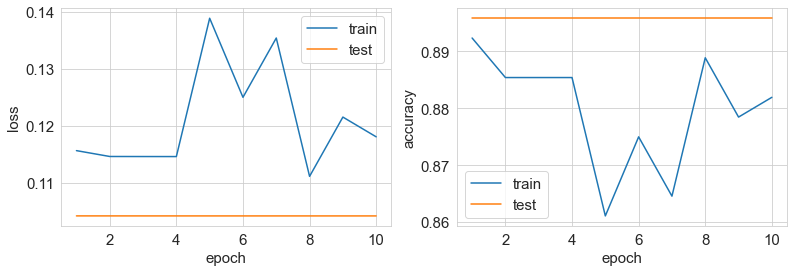

In [157]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, NUM_EPOCHS, 1)